In [1]:
%reset-f


In [2]:
%load_ext autoreload
%autoreload
%matplotlib inline
from pandas.io import wb

import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from res_ind_lib import *
import os, time
import warnings
import fileinput
from subprocess import call

from IPython.display import SVG,Image
from maps_lib import *
import pandas as pd

warnings.filterwarnings("always",category=UserWarning)

###Data

In [3]:
#Get resilience, country name, and iso2
df = pd.read_csv('df.csv').dropna().set_index("iso3")
iso3_to_iso2 = pd.read_csv("names_to_iso.csv",usecols=["iso2","iso3"]).drop_duplicates().set_index("iso3")

df["iso2"]=iso3_to_iso2["iso2"]

cond = df["iso2"].isnull()
if cond.sum()>0:
    warnings.warn("no iso2 codefound for ", ",".join(data.index[cond].values))

#data=data.reset_index().set_index("iso2").drop("iso3",axis=1)

df["logrisk"] = np.log10(df.risk)

df["resi_color"]=data_to_rgb(df.resilience)
df["risk_color"]=data_to_rgb(df.risk,plt.cm.get_cmap("Reds"))
df["log_risk_color"]=data_to_rgb(df.logrisk,plt.cm.get_cmap("Reds"))

###Export map data

In [4]:
df[["country",'resilience',"resi_color","risk", "risk_color"]].to_csv('data_for_map.csv')

###Map

In [5]:
style_base =\
""".landxx.{iso2}
{{  
   fill: {color};
   stroke:#000000;
   stroke-width:0.3;
   fill-rule:evenodd;
}}"""

styles_rl=styles_r=styles=""
for c in df.index:
    styles = styles     + style_base.format(iso2=df["iso2"][c].lower(),color=df["resi_color"][c])+ "\n"
    styles_r = styles_r + style_base.format(iso2=df["iso2"][c].lower(),color=df["risk_color"][c])+ "\n"
    styles_rl = styles_rl + style_base.format(iso2=df["iso2"][c].lower(),color=df["log_risk_color"][c])+ "\n"
    
append_styles_to_map("map_of_resilience",styles)
append_styles_to_map("map_of_risk",styles_r)
append_styles_to_map("map_of_log_risk",styles_rl)

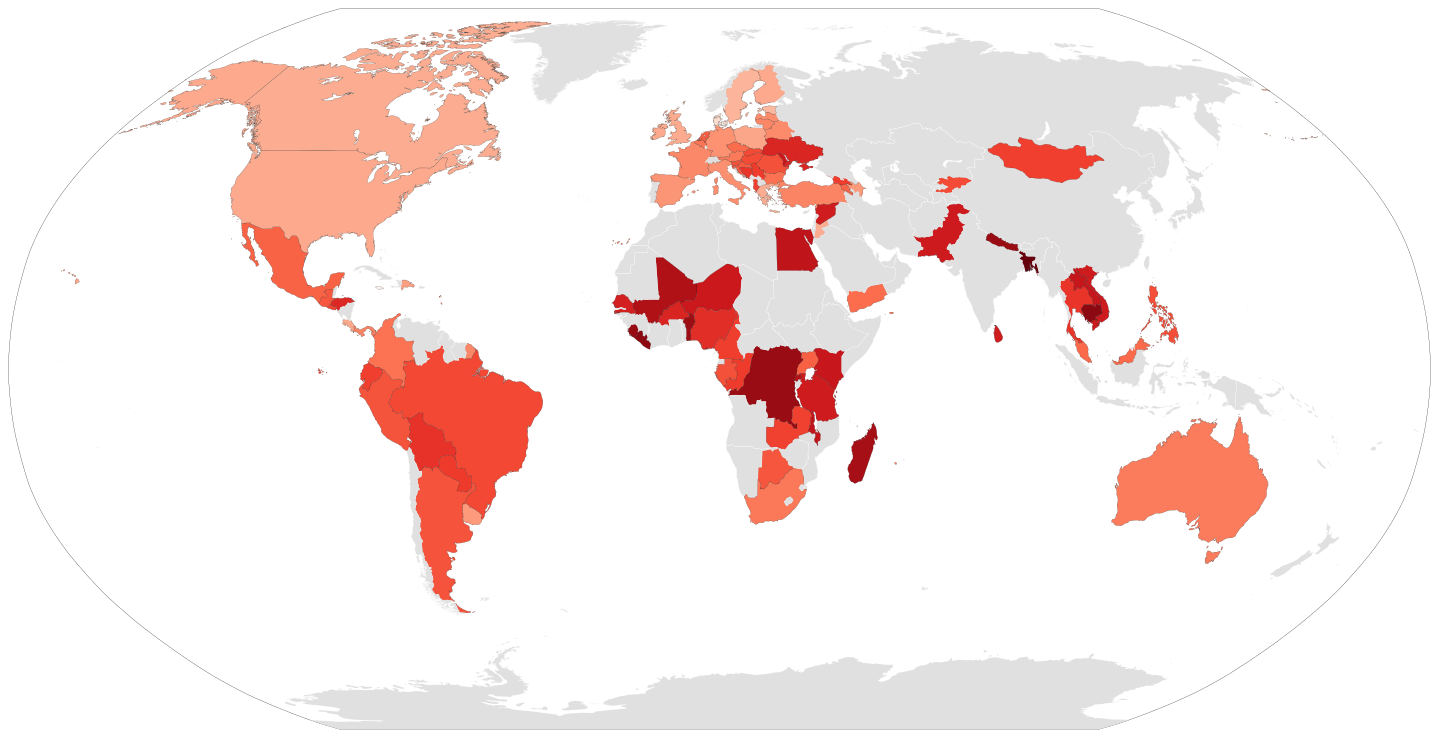

In [6]:
Image("map_of_log_risk.png",width=700)

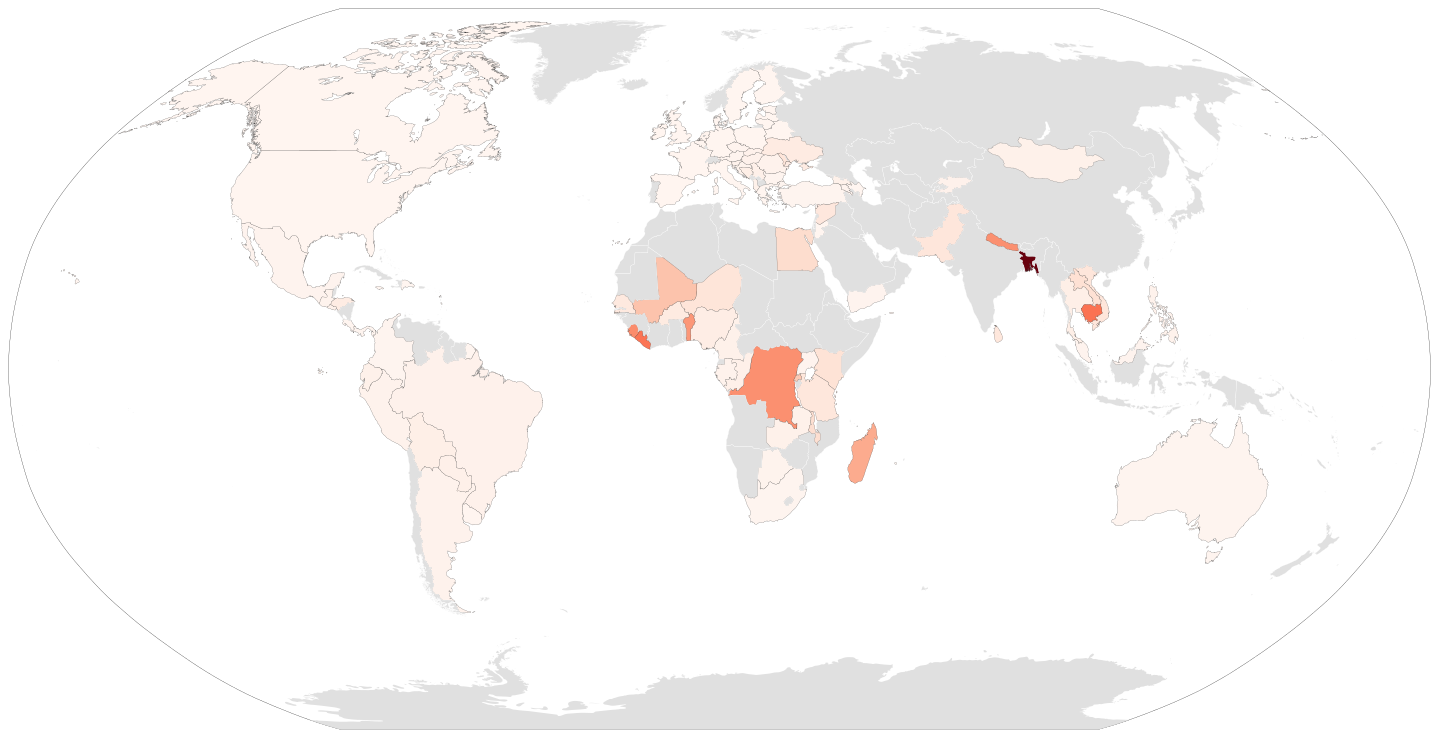

In [7]:
Image("map_of_risk.png",width=700)

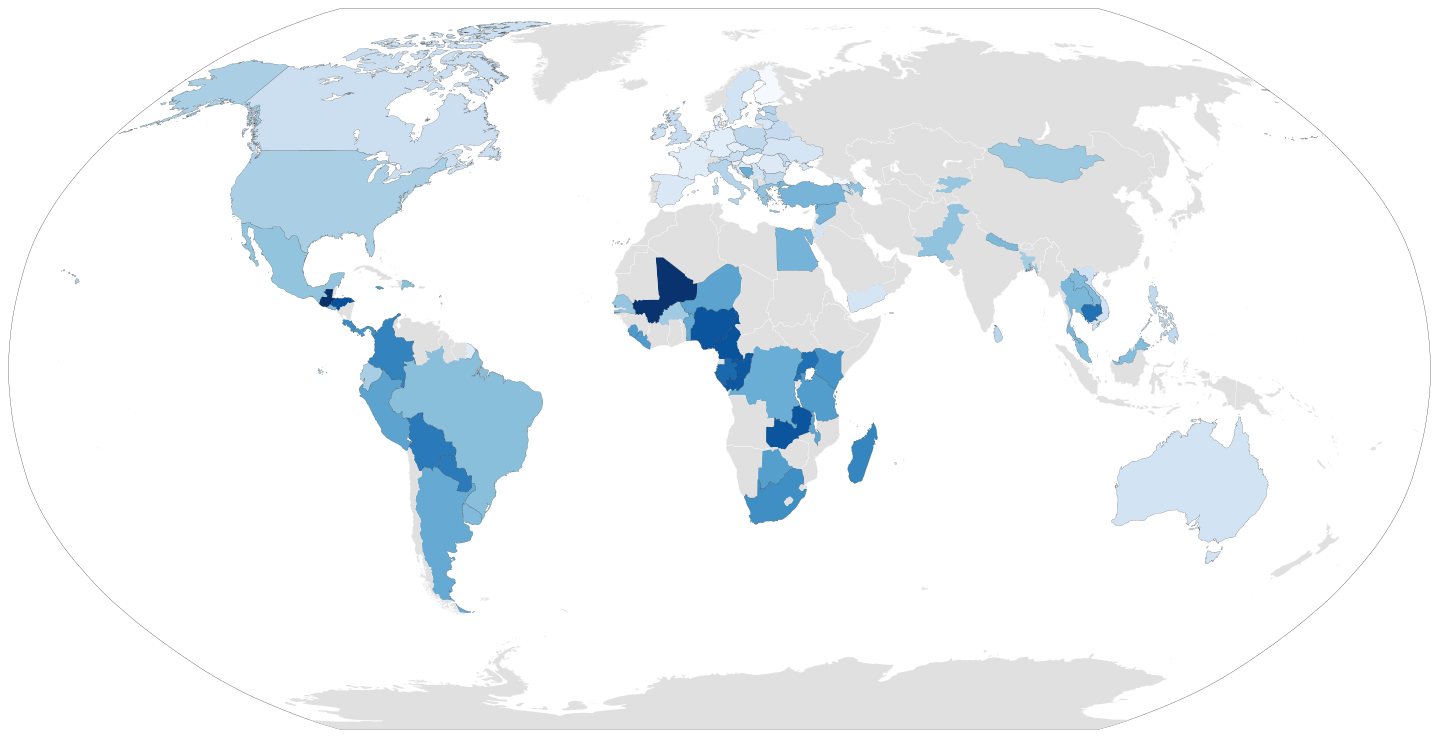

In [8]:
Image("map_of_resilience.png",width=700)

#Legend

In [9]:

font = {'family' : 'sans serif',
    'size'   : 22}



plt.rc('font', **font)
plt.rcParams["savefig.dpi"]=90

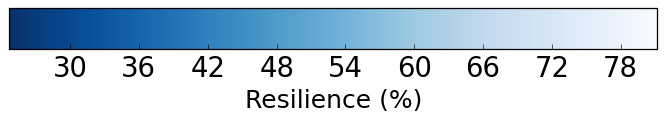

In [10]:
import matplotlib as mpl


fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cmap = mpl.cm.get_cmap("Blues_r")
norm = mpl.colors.Normalize(vmin=df.resilience.min()*100, vmax=df.resilience.max()*100)


cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm,
                                   orientation='horizontal')
cb.set_label('Resilience (%)',size=20)
plt.savefig("legend_resilience.png",bbox_inches="tight",transparent=True)

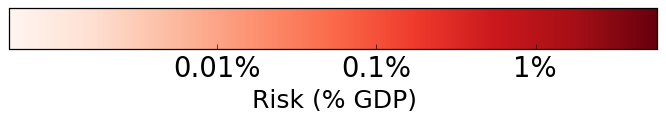

In [11]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cmap = mpl.cm.get_cmap("Reds")
norm = mpl.colors.Normalize(vmin=(df.logrisk.min()), vmax=(df.logrisk.max()))


cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm,
                                   orientation='horizontal',ticks=range(-4,0))
cb.ax.set_xticklabels(['0.01%','0.1%','1%','10%'])
cb.set_label('Risk (% GDP)',size=20)

plt.savefig("legend_log_risk.png",bbox_inches="tight",transparent=True)

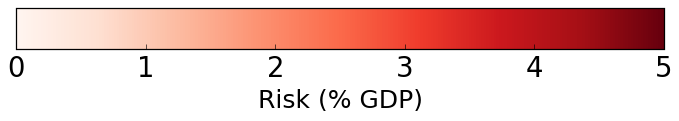

In [12]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cmap = mpl.cm.get_cmap("Reds")
norm = mpl.colors.Normalize(vmin=int(df.risk.min()*100), vmax=int(df.risk.max()*100))


cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                   norm=norm,
                                   orientation='horizontal',ticks=range(0,15))
cb.set_label('Risk (% GDP)',size=20)

plt.savefig("legend_risk.png",bbox_inches="tight",transparent=True)

### Example: how to build own  color map

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#Example: building one's own colormap (not used)
cMap = []
#for value, colour in zip([0,1,2,3,4],["#d7191c", "#fdae61", "#ffffbf", "#abd9e9", "#2c7bb6"]):
for value, colour in zip([0,1,2,3,4,5,6],["#d73027", "#fc8d59", "#fee090", "#ffffbf", "#e0f3f8", "#91bfdb", "#4575b4"]):
    cMap.append((value/6, colour))
colorMap = LinearSegmentedColormap.from_list("custom", cMap)

 
